# Contexte du projet


Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans **le diagnostic automatisé de la pneumonie à partir de radios thoraciques.** Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’**un système de classification binaire d’images médicales**.

>Le problème posé consiste à réutiliser un modèle de vision par ordinateur **pré-entraîné (type CNN)** pour l’adapter au contexte médical, sans repartir d’un entraînement complet.

> Dans une logique de mise en production à moyen terme, il est également attendu de documenter et tracer les expérimentations réalisées. L’usage de **MLflow** est proposé pour initier cette démarche, en assurant le suivi des performances, la traçabilité des essais et la gestion des versions de modèles dans une perspective MLOps.

# Modalités d'évaluation
Évaluation individuelle à partir du livrable (notebook). 
Le barème porte sur 
- **la qualité de la démarche (pertinence des choix, rigueur des étapes, clarté des explications),** 
- **la bonne compréhension du transfert learning,**
- **et l’initiation à MLflow (usage basique)**.

# Livrables
Un **lien GitHub** contenant les travaux réalisés, notamment un notebook complet, structuré, lisible et commenté, incluant :
- Préparation et exploration du dataset
- Mise en place du modèle pré-entraîné et adaptation
- Entraînement, évaluation (matrice de confusion, courbes, métriques etc...)
- Suivi des expériences via MLflow
- Le dépôt du code sur GitHub avec les travaux réalisé (notebook) avec un README synthétique

# Critères de performance
- Le notebook couvre toutes **les étapes clés de la démarche** (pré-traitement, modélisation, évaluation)
- Les **choix techniques sont justifiés** avec clarté et cohérence
- Le **modèle est adapté** de manière correcte à la tâche de classification binaire
- L’**évaluation du modèle est rigoureuse** (métriques pertinentes, commentaires clairs)
- La première utilisation de **MLflow est fonctionnelle et comprise** (log simple de paramètres ou de métriques)
- Le **code est structuré, commenté, exécutable**
- *La performance du modèle n'est pas un critère de performances, seul compte la démarche, la compréhension et donc la clarté des notes dans le le notebook*

----

# 1. Chargement des bibliothèques nécessaires

 - Création du fichier requirements.txt contenant les bibliothèques à installer
 - Création d'un environnment virtuel `python -m venv .venv` et l'activer ` .\.venv\Scripts\Activate.ps1`
 - Installer les bibliothèques `pip install - requirements.txt` 
 - choisir le dossier .venv dans "Python: Select interpreter" (Command Palette)
 (venv contenant python 3.10 compatible avec tensorflow)
 - installer ipykernel pour executer

In [1]:
import os  # os pour manipuler des dossiers et fichiers
import numpy as np # np pour manipuler des vecteurs et matrices
import pandas as pd # pd pour traiter des dataframe et visualiser des figures
import seaborn as sns # pd pour visualiser des figures

import mlflow #  pour documenter et tracer les expérimentations réalisées.
import mlflow.tensorflow
# DL Lib
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense 

import matplotlib.pyplot as plt  #  pour visualiser des figures
from sklearn.metrics import confusion_matrix, classification_report # pd pour évaluer le modèle
import cv2
#from tensorflow import keras
#from keras.models import Model
#from keras.layers import Dense
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# 2. Préparation et exploration du dataset

## Chargement des données

In [2]:
def get_train_val(base_path: str):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
    for label in sorted(os.listdir(base_path)):
        # on ignore les fichiers qui ne sont pas des dossiers de chiffres
        if label not in ["NORMAL","PNEUMONIA"]:
            continue
        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            # Convert to 3 channels
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Now shape is (H, W, 3)
            # Resize to model input size (e.g., 224x224)
            resized_img = cv2.resize(img_rgb, (224, 224))
            
            if img is None:
                continue  # image illisible, on passe
            X.append(resized_img)           # on ajoute l'image à la liste
            y.append(1 if label == "PNEUMONIA" else 0)    # on ajoute le label (1 if label == "PNEUMONIA" else 0)

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_val("data/train")
X_val, y_val = get_train_val("data/val")
X_test,y_test = get_train_val("data/test")

## Vérification

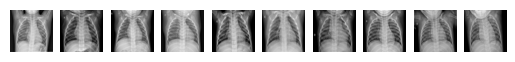

In [3]:
# Vérification des données préparées
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.show()

## Conversion et normalisation

- La conversion des entiers (0–255) en nombres à virgule (float32)
- La normalisation des pixels entre 0.0 et 1.0

In [5]:
# Les images sont au format (224, 224). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_val /= 255.0

# 3. Modélisation

- Pour un transfer learning : choisir le modèle de base pré-entrainé DenseNet121

In [7]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Option 1: 128 neurons
x = Dense(128, activation='relu')(x)

# Option 2: 256 neurons (original)
# x = Dense(256, activation='relu')(x)

# Option 3: 512 neurons
# x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


In [14]:
model_densenet = Model(inputs=base_model.input, outputs=predictions)


Stratégie #2 : extraction de features
On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :

In [15]:
for layer in base_model.layers:
    layer.trainable = False


# 4. Compilation

In [16]:
model_densenet.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# 5. Auto-tracking 

In [13]:
import mlflow.tensorflow


mlflow.tensorflow.autolog()
mlflow.set_experiment("Keras-TransferLearning-CNN-DenseNet")

2025/05/22 14:51:08 INFO mlflow.tracking.fluent: Experiment with name 'Keras-TransferLearning-CNN-DenseNet' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/mlruns/151601853767064718', creation_time=1747918268094, experiment_id='151601853767064718', last_update_time=1747918268094, lifecycle_stage='active', name='Keras-TransferLearning-CNN-DenseNet', tags={}>

# 5. Fitting

In [17]:
with mlflow.start_run(run_name="Pneumonia-vs-Normal"):
    history = model_densenet.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=32,
        shuffle=True
    )
     # log the model
    mlflow.keras.log_model(model_densenet,"model")
    mlflow.set_tag("model_type", "DenseNet121")
    mlflow.set_tag("dataset", "ChestX-ray")

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6098 - loss: 0.6842

163/163 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.6103 - loss: 0.6839 - val_accuracy: 0.5000 - val_loss: 0.8305
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


2025/05/22 15:08:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/22 15:08:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [18]:
print(model_densenet.summary())  # Verify the model architecture

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,431,493 (28.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 262,660 (1.00 MB)

None


In [20]:
type(history.history)

dict

In [19]:
model_densenet.save('my_model_densenet.keras')


# 6. Evaluation

In [21]:
# Evaluate after training
loss, accuracy = model_densenet.evaluate(X_val,y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.8305
Validation Accuracy: 50.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
 [[0 8]
 [0 8]]


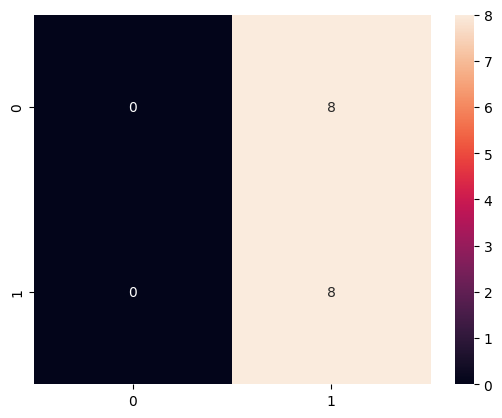

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions
y_pred_prob = model_densenet.predict(X_val)
y_pred = np.round(y_pred_prob)  # Assuming binary classification with sigmoid



# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm,annot=True)
plt.savefig('confusion_matrix2.png')
print("Confusion Matrix:\n", cm)


# 7. Logging artifacts

In [25]:
# List all experiments
experiments = mlflow.search_experiments()

In [26]:
for exp in experiments:
    print(f"Experiment ID: {exp.experiment_id}, Experiment Name: {exp.name}")

Experiment ID: 151601853767064718, Experiment Name: Keras-TransferLearning-CNN-DenseNet
Experiment ID: 450179581705358082, Experiment Name: Keras-TransferLearning-CNN
Experiment ID: 253621991807162019, Experiment Name: Keras-TransferLearning-CNN-PostTraining
Experiment ID: 0, Experiment Name: Default


In [59]:
type(experiments)

list

In [27]:

experiment_id = "151601853767064718"
# Search for runs in the specified experiment, sorted by start time in descending order
runs = mlflow.search_runs(experiment_ids=[experiment_id])

print(runs)



                             run_id       experiment_id    status  \
0  2252e3f821ed4421aa13993a410ff364  151601853767064718  FINISHED   

                                        artifact_uri  \
0  file:///c:/Users/User/Desktop/DL_transfer_CNN_...   

                        start_time                         end_time  \
0 2025-05-22 12:58:43.832000+00:00 2025-05-22 13:08:52.438000+00:00   

   metrics.validation_accuracy  metrics.accuracy  metrics.val_accuracy  \
0                          0.5          0.693443                   0.5   

   metrics.loss  ...  params.opt_clipnorm  params.opt_clipvalue  \
0      0.626108  ...                 None                  None   

  tags.model_type tags.mlflow.latest_checkpoint_artifact tags.mlflow.user  \
0     DenseNet121       checkpoints/latest_checkpoint.h5             User   

  tags.dataset tags.mlflow.source.type  \
0   ChestX-ray                   LOCAL   

                       tags.mlflow.log-model.history  tags.mlflow.runName  \
0  [

In [28]:
mlflow.log_artifact("confusion_matrix2.png")

In [29]:
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=['Normal', 'Pneumonia']))


Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         8
   Pneumonia       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



c:\Users\User\Desktop\DL_transfer_CNN_pneumonia\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\DL_transfer_CNN_pneumonia\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\DL_transfer_CNN_pneumonia\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

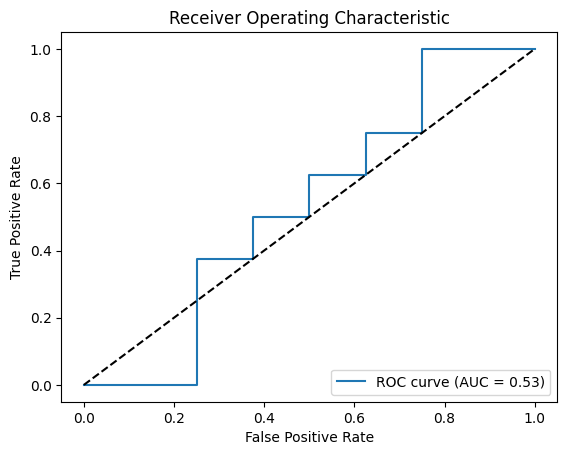

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.savefig('ROC2.png')
plt.legend(loc='lower right')
plt.show()


In [31]:
mlflow.log_artifact('ROC2.png')

---

## Mlflow ui
`mlflow ui `
- ouvrir http://localhost:5000